### Analysis software development v2 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import lmfit as lm

# import data handling class
from DT5550 import *
from scipy.special import legendre

Open a datafile and read the data

In [2]:
#
# open the datfile / data directory
#
    
#
# loop over all the events
#
dt_max = 10

Etot = []
Etot_sel = []

ee = []
ee_1173 = []
ee_1330 = []
for i in range(8):
    ee.append([])
    ee_1173.append([])
    ee_1330.append([])


nmax = 9999
idet_old = 0

#    while io.read_event() == 0:
#        #
#        # data: io.Q[0:ndet-1] -> energy
#        #       io.ph[0:ndet-1] -> peak height
#        #       io.t[0:ndet-1] -> time without timewalk correction
#        #       io.tc[0:ndet-1] -> time with timewalk correction
#        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
#        #       io.R[0:ndet-1] -> peak/area ratio


# tagged
io = DT5550(indir='C:/data/20220110_165917/')
nf = 0

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0: 
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        #       io.R[0:ndet-1] -> peak/area ratio
        nh = io.valid.sum()

        # events with two hits
        if nh == 2:
            id_sel = []
            for idet in range(8):
                if io.valid[idet]:
                    id_sel.append(idet)
                    
            id0 = id_sel[0]
            id1 = id_sel[1]
            #  the total measured energy
            Etot.append(io.Q.sum()) 
            
            delta_t = io.tc[id1] - io.tc[id0]
            if id0 == 0:
                if abs(delta_t) < dt_max:
                    Esum = io.Q[id0] + io.Q[id1]
                    Etot_sel.append(Esum)
                    if io.Q[id0]>1250 and io.Q[id0]<1450:
                        ee_1173[id1].append(io.Q[id1])
                        ee_1173[id0].append(io.Q[id0])

                    if io.Q[id0]>1100 and io.Q[id0]<1250:
                        ee_1330[id1].append(io.Q[id1])
                        ee_1330[id0].append(io.Q[id0])

print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
ee = np.array(ee,dtype=object)
ee_1173 = np.array(ee_1173,dtype=object)
ee_1330 = np.array(ee_1330,dtype=object)

#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220110_165917\config_20220110_165917.json
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_0.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_1.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_2.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_3.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_4.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_5.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_6.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_7.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_8.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_9.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_10.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_11.r

#### Define fit functions

In [521]:
from scipy.optimize import curve_fit
from lmfit import Model

def legendre_polynomial(x, A, c2, c4):
    p = [A, c2, c4]
    
    P0 = legendre(0)
    P2 = legendre(2)
    P4 = legendre(4)
    
    return p[0]*(P0(x) + p[1]*P2(x) + p[2]*P4(x))

def legendre_fit(x, y, yerr, **kwargs):
    """
    Fit Legendre polynomials
    """
    p0 = [12000, 0.1, 0.001]
    
    #fit_par, cov = curve_fit(legendre_polynomial, x, y, sigma=yerr, p0=p0)

    # lmfit it....
    gmodel = Model(legendre_polynomial)
    result = gmodel.fit(y, x=x, A=p0[0], c2=p0[1], c4=p0[2])
    print(result.fit_report())
    
    fit_par = np.zeros(3)
    fit_err = np.zeros(3)
    
    fit_par[0] = result.params['A'].value
    fit_par[1] = result.params['c2'].value
    fit_par[2] = result.params['c4'].value
    
    fit_err[0] = result.params['A'].stderr
    fit_err[1] = result.params['c2'].stderr
    fit_err[2] = result.params['c4'].stderr
    
    return fit_par, fit_err

def gauss(x, A, mu, sigma):
    p = [A, mu, sigma]
    return p[0] / np.sqrt(2*np.pi) / p[2] * ( np.exp(-((x - p[1]) / p[2]) ** 2 / 2))

def gauss_fit(data, **kwargs):
    """
    Fit a Gaussian to a distribution
    """
    p0 = kwargs.pop('p0', (1, 1, 1))
    fit_range = kwargs.pop('range', (0, 3000))
    bins = kwargs.pop('bins', 100)

    data = data[data>fit_range[0]]
    data = data[data<fit_range[1]]
    
    bw = (fit_range[1] - fit_range[0])/bins

    # fit a Gaussian to the delta_t distribution
    y, xe = np.histogram(data, bins=bins, range=fit_range)
    x = .5 * (xe[:-1] + xe[1:])
    # lmfit it....
    gmodel = Model(gauss)
    result = gmodel.fit(y, x=x, weights=1, A=p0[0], mu=p0[1], sigma=p0[2])

    fit_par = np.zeros(3)
    fit_err = np.zeros(3)
    
    fit_par[0] = result.params['A'].value / bw
    fit_par[1] = result.params['mu'].value
    fit_par[2] = result.params['sigma'].value
    
    fit_err[0] = result.params['A'].stderr / bw
    fit_err[1] = result.params['mu'].stderr
    fit_err[2] = result.params['sigma'].stderr

    return fit_par, fit_err

#### Tag and Count events

1  N= 6141.21702816573  D= 78.36591751626297  N count = 6192
2  N= 6089.684465727707  D= 78.03643037535551  N count = 6180
3  N= 5813.876907307714  D= 76.24878298902688  N count = 5908
4  N= 5623.129442321101  D= 74.98752857856499  N count = 5697
5  N= 5416.490108212667  D= 73.59680773112831  N count = 5456
6  N= 5290.072773169652  D= 72.7328864625188  N count = 5308
7  N= 5195.494217772289  D= 72.07977676000591  N count = 5225


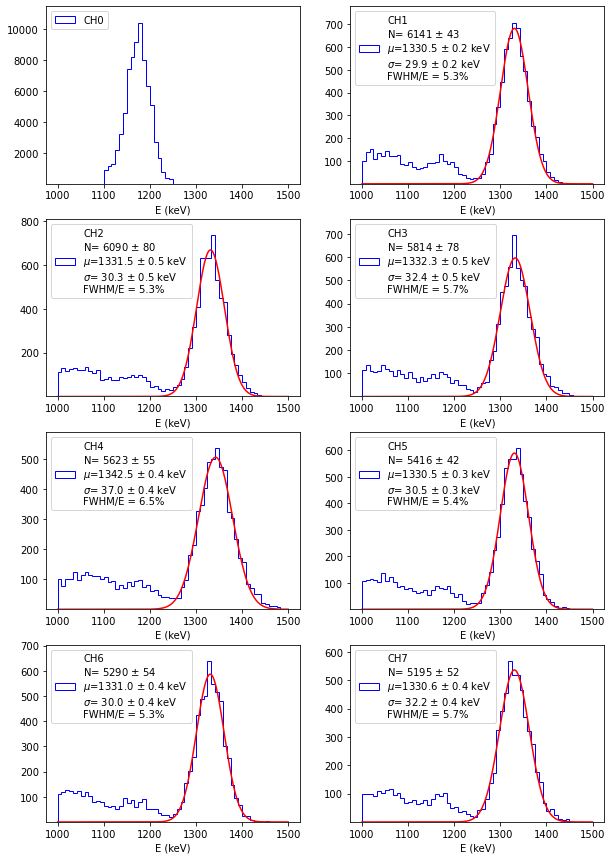

In [543]:
# pk_sel = 0: tag the 1330keV gammas and count the 1173keV gammas in the other detectors
#        = 1: tag the 1173keV gammas and count the 1330keV gammas in the other detectors
pk_sel = 1

plot_range = (1000, 1500)
p0 = []
ee_data = []
tag_data = []

if pk_sel == 0:
    fit_range = (1100, 1250) # select the appropriate energy range for thr fit
    p0=[1000, 1173, 20]
    ee_data = ee_1173
    tag_data = np.array(ee_1173[0])
else:
    fit_range = (1250, 2000)
    p0=[1000, 1330, 20]
    ee_data = ee_1330
    tag_data = np.array(ee_1330[0])

# define x-variable for plotting teh fittted functions
bins = 60
bin_width = (plot_range[1] - plot_range[0])/bins
xx = np.linspace(plot_range[0],plot_range[1],1000)

n_tag = np.zeros(8)
dn_tag = np.zeros(8)

plt.figure(figsize=(10,15))

for idet in range(8):
    plt.subplot(4, 2, 1+idet)

    if idet == 0:
        txt = 'CH{:1d}'.format(idet)
        y, _, _ = plt.hist(tag_data, bins=bins, range=plot_range, histtype='step', color='blue', label=txt)
    else:
        data = np.array(ee_data[idet])
        fit, err = gauss_fit(data, range=fit_range, bins=int((fit_range[1]-fit_range[0])/bin_width), p0=p0)
        fwhm = 2.35*fit[2]/fit[1]*100
        txt = 'CH{:1d}\nN={:5.0f} $\pm$ {:2.0f} \n$\mu$={:5.1f} $\pm$ {:3.1f} keV \n$\sigma$={:5.1f} $\pm$ {:3.1f} keV\nFWHM/E = {:3.1f}%'.format(idet,fit[0],err[0],fit[1],err[1],fit[2],err[2],fwhm)
        y, _, _ = plt.hist(data, bins=bins, range=plot_range, histtype='step', color='blue', label=txt)
        plt.plot(xx, bin_width*gauss(xx, fit[0], fit[1], fit[2]), color='red')
                 
        n_tag[idet] = fit[0]
        dn_tag[idet] = np.sqrt(n_tag[idet])
        data = data[data>fit_range[0]]
        data = data[data<fit_range[1]]
        print(idet,' N=',n_tag[idet], ' D=',dn_tag[idet],' N count =',len(data))
    if pk_sel == 1:
        plt.legend(loc='upper left')    
    else:
        plt.legend(loc='upper right')
    plt.xlabel('E (keV)')
    plt.yscale('linear')
    plt.ylim([0.6,1.1*max(y)])

#### Fit 4th order legendre polynomial to the observed correlation curve

[[Model]]
    Model(legendre_polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 7
    # variables        = 3
    chi-square         = 4481.89484
    reduced chi-square = 1120.47371
    Akaike info crit   = 51.2332373
    Bayesian info crit = 51.0709677
[[Variables]]
    A:   5492.42070 +/- 14.2809201 (0.26%) (init = 12000)
    c2:  0.10661046 +/- 0.00476727 (4.47%) (init = 0.1)
    c4:  0.01168909 +/- 0.00568203 (48.61%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c4) = -0.479
    C(A, c2)  = -0.267
    C(A, c4)  = -0.255


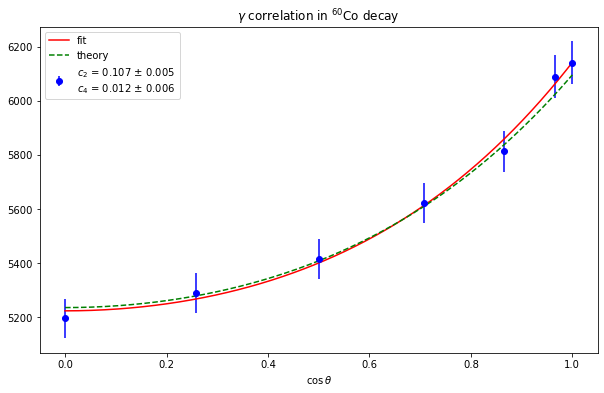

In [544]:

# make an array with cos(theta) values
x = np.arange(1,8,1)
theta = (7-x)*(np.pi/12)+np.pi/2
cost = abs(np.cos(theta))

data = n_tag[1:8]
yerr = dn_tag[1:8]
#
# fit the data
#
fit, err = legendre_fit(cost, data, yerr=yerr)
#
# plot the data
#
txt = '$c_2$ = {:4.3f} $\pm$ {:4.3f} \n$c_4$ = {:4.3f} $\pm$ {:4.3f}'.format(fit[1],err[1],fit[2],err[2])
plt.figure(figsize=(10,6))
h = plt.errorbar(cost, data, yerr=yerr, fmt = 'o', color='blue', label=txt)
#
# plot the fit to the data
#
xx = np.linspace(0,1,500)
plt.plot(xx, legendre_polynomial(xx, fit[0], fit[1], fit[2]),'-',color='red', label='fit')
plt.plot(xx, legendre_polynomial(xx, fit[0], 0.1005, 0.0094), '--', color='green', label='theory' )
plt.xlabel('$\cos \\theta$')
plt.legend()
plt.title("$\gamma$ correlation in $^{60}$Co decay")

plt.show()